In [4]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x1': load_data('../stats/fpm_4_2D_x1.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
    # 'Num cells x8': load_data('../stats/fpm_4_x2.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
    # 'Num cells x27': load_data('../stats/fpm_4_x3.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

In [5]:
from fpm_5_2D import make_model

model = make_model()
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 32


In [16]:
mat_idx = 15
entry = data['Num cells x1']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

18


In [17]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

8
0
19
5


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.03
True residual decrease: 1.9221007175420283e-10


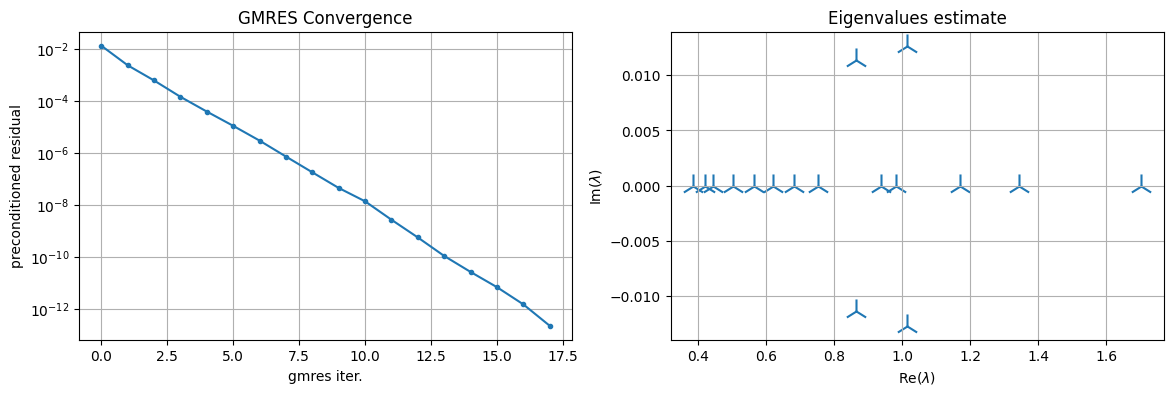

In [18]:
solve_petsc(perm_mat.mat, prec_orig, rhs=model.rhs_Q, pc_side='left')

Solve  took: 0.03
True residual decrease: 2.8453192067511464e-11


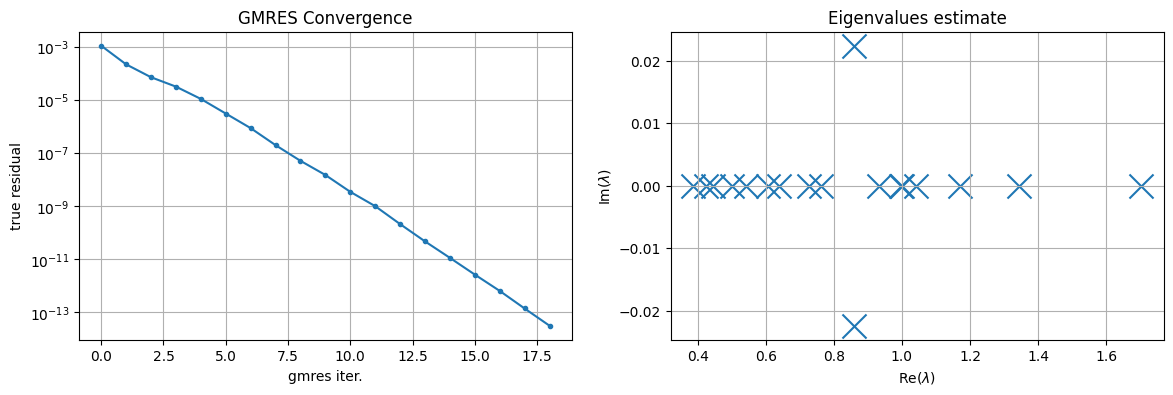

In [38]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: model._fixed_stress.mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=J)
solve_petsc(bmat_reordered.mat, preconditioner, rhs=model.rhs_Q, pc_side='right')

In [39]:
# from fixed_stress import make_local_stab_15

# fs_expected = make_local_stab_15(bmat=J, base=2, nd=1)
# plot_mat(fs_expected)
# print(fs_expected.data)

In [40]:
def get_fs_fractures_analytical(model):
    alpha_biot = model.solid.biot_coefficient()  # [-]
    lame_lambda = model.solid.lame_lambda()  # [Pa]
    M = 1 / model.solid.specific_storage()  # [Pa]
    compressibility = model.fluid.compressibility()  # [1 / Pa]
    porosity = model.solid.porosity()

    val = alpha_biot**2 / (lame_lambda * (1 / (compressibility * M) + porosity))

    fractures = [
        frac
        for dim in reversed(range(model.nd))  
        for frac in model.mdg.subdomains(dim=dim)
    ]
    cell_volumes = np.concatenate([f.cell_volumes for f in fractures])
    val *= cell_volumes

    # intersections ?

    # ambient dimension ?

    # specific volume ?
    # specific_volume = model.specific_volume(fractures).value(model.equation_system)

    density = model.fluid_density(fractures).value(model.equation_system)
    val *= density

    dt = model.time_manager.dt
    val /= dt

    return scipy.sparse.diags(val)


get_fs_fractures_analytical(model).data

array([[5.27320847e-09, 5.27331061e-09, 5.34605613e-09, 5.34613395e-09,
        2.99144545e-09, 3.86255850e-09, 3.86486390e-09, 2.98810705e-09,
        3.15493722e-09, 4.13152984e-09, 3.70722292e-09, 3.57786707e-09,
        4.72042087e-09, 4.72098552e-09, 4.72191859e-09, 4.84295546e-09,
        2.77024538e-09, 2.07314359e-09, 2.29038764e-09, 3.14165257e-09,
        4.30946959e-09, 5.68206074e-09, 4.06274716e-09, 2.14014562e-09,
        2.88443462e-09, 3.88719484e-09, 4.45320912e-09, 4.45124096e-09,
        1.68653381e-09, 2.23996148e-09, 2.02183330e-09, 1.90477194e-09,
        3.51554277e-08]])

# Trying new Fixed Stress

Solve  took: 0.03
True residual decrease: 5.3818795057900895e-11


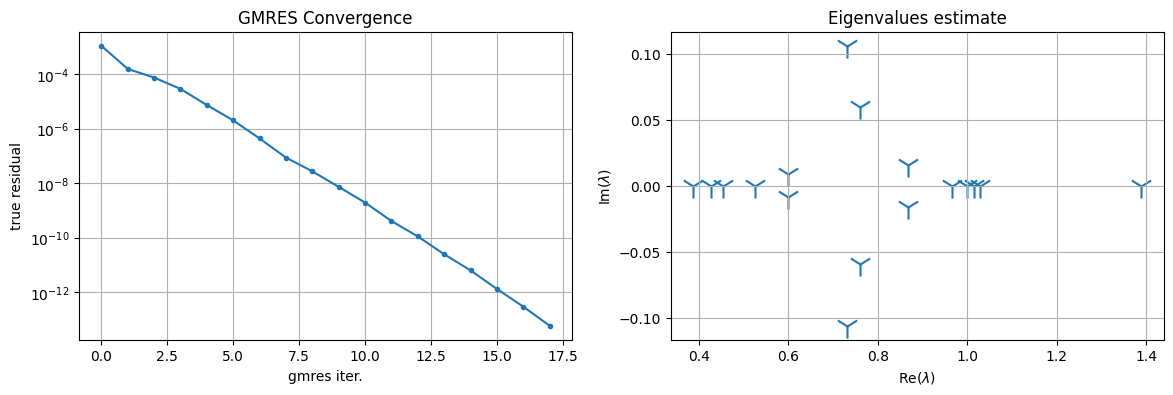

In [43]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs, get_fixed_stress_stabilization


def make_fs_experimental(model, J):
    diag = [
        get_fixed_stress_stabilization(model),
        get_fs_fractures_analytical(model),
    ]
    result = J.empty_container()[[0, 2]]
    result.mat = scipy.sparse.block_diag(diag, format="csr")
    return result


schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=J)
solve_petsc(bmat_reordered.mat, preconditioner, rhs=model.rhs_Q, pc_side='right')

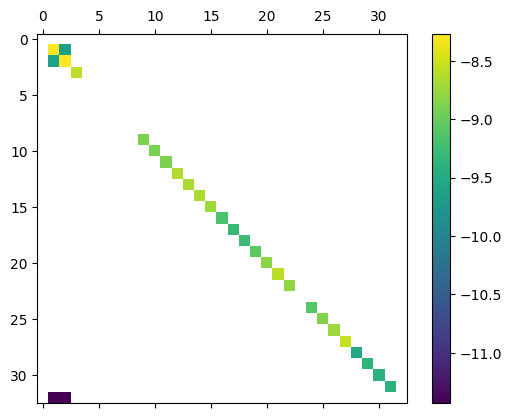

In [33]:
model._fixed_stress[2, 2].matshow()

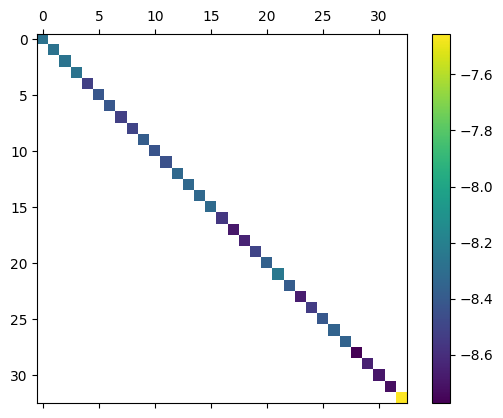

In [42]:
make_fs_experimental(model, J)[2, 2].matshow()